In [1]:
import json
import numpy as np
import pytorch_lightning as pl
from torch import nn
from torch.utils.data import DataLoader,Dataset
import os
import librosa
import audioread
import torch
import torchmetrics

c:\Users\joshuaku\Anaconda3\envs\ml\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# MFCC parameters
N_FFT = 2048
N_MFCC = 13
N_MELS = 10
HOP_LENGTH = 512
NUM_SEGMENTS = 5
DURATION = 29
N_FEATURES = 1058

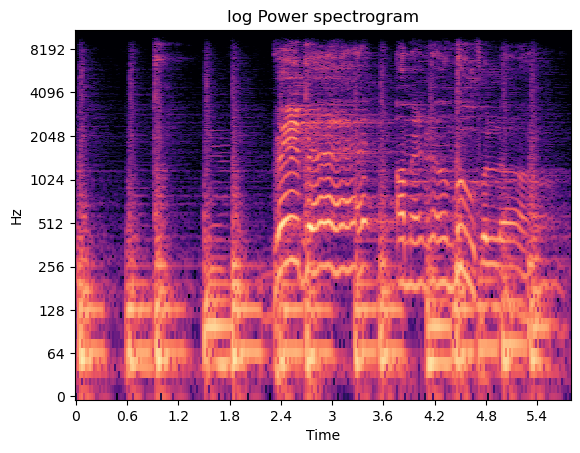

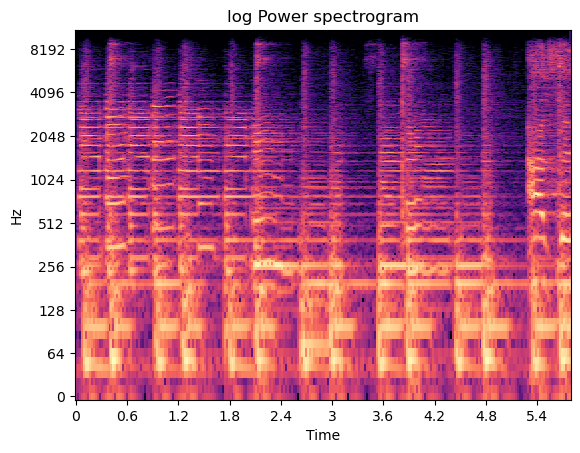

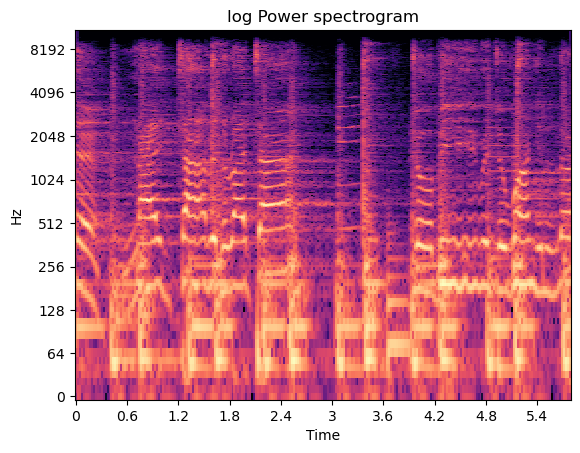

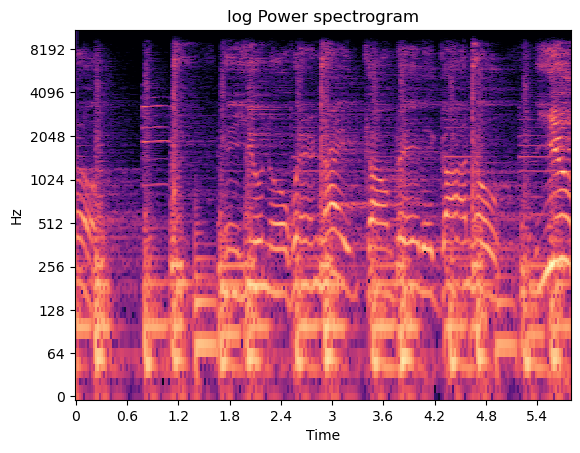

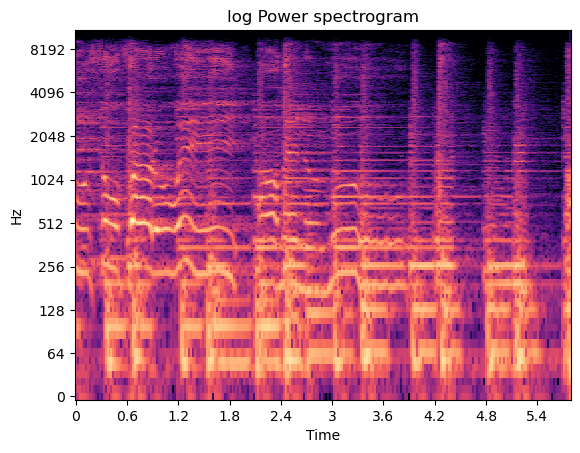

(250, 1058)


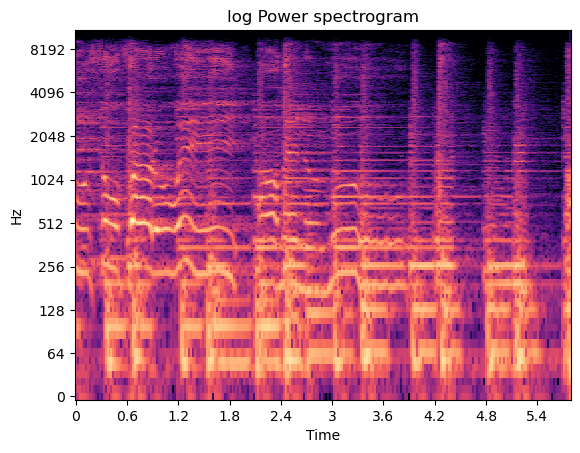

In [3]:
from IPython.display import Audio,display
import matplotlib.pyplot as plt
plt.clf()

def extract_audio_feature(file_path,play=False):
    try:
        signal, sr = librosa.load(file_path)
    except Exception as e:
        print("FREAD ERROR: ", file_path,e)
        return None

    num_samples_per_segment = sr * DURATION // NUM_SEGMENTS
    full_arr = []
    for s in range(NUM_SEGMENTS):
        start_sample = num_samples_per_segment * s
        finish_sample = start_sample + num_samples_per_segment
        
        current_segment = signal[start_sample:finish_sample]
            
        mfcc = librosa.feature.mfcc(
            y=current_segment,
            sr=sr,
            n_fft=N_FFT,
            n_mfcc=N_MFCC,
            hop_length=HOP_LENGTH,
        )
        
        S, phase = librosa.magphase(librosa.stft(y=current_segment, n_fft=N_FFT, hop_length=HOP_LENGTH))
        #librosa.display.specshow((librosa.amplitude_to_db(S, ref=np.max)), y_axis='log', x_axis='time')
        #plt.show()
        
        magphase = librosa.amplitude_to_db(S, ref=np.max)        
        spectral_center = librosa.feature.spectral_centroid(y=current_segment, n_fft=N_FFT, hop_length=HOP_LENGTH)
        chroma = librosa.feature.chroma_stft(y=current_segment, n_fft=N_FFT, hop_length=HOP_LENGTH)
        spectral_contrast = librosa.feature.spectral_contrast(y=current_segment, n_fft=N_FFT, hop_length=HOP_LENGTH)
            
        if play:
            #fig, ax = plt.subplots(nrows=2, sharex=True)
            #times = librosa.times_like(spec_bw)
            librosa.display.specshow(magphase,y_axis='log', x_axis='time')
            #plt.set(title='log Power spectrogram')
            #librosa.display.waveshow(current_segment, sr=sr)
            plt.title("log Power spectrogram")
            display(plt.gcf())
            #plt.clf()
            display(Audio(current_segment,rate=sr))
            # print(magphase.T.shape, spectral_center.T.shape, chroma.T.shape, spectral_contrast.T.shape, mfcc.T.shape)
        
        # 1025 + 1 + 12 + 7 + 13 = 1058 features
        combined_features = np.concatenate((magphase.T, spectral_center.T, chroma.T, spectral_contrast.T, mfcc.T), axis=1)
        full_arr.append(combined_features)

        # Maybe you don't need this        
        # mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS, fmax=8000)
        # log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
        # log_mel_spectrogram = log_mel_spectrogram.T
        # print(log_mel_spectrogram.shape)
        
    return full_arr

tgenre = "blues"
print(extract_audio_feature(rf"datasets\archive\Data\genres_original\{tgenre}\{tgenre}.00001.wav",play=True)[0].shape)

### Split Train Test sets

In [4]:
class GTZAND(Dataset):
    def __init__(self,path,force_preprocess=False):
        self.path = path
        self.y = []
        
        self.data = self.pre_process_and_save(force_preprocess)
        self.genre_list = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
    
    def pre_process_and_save(self,force_preprocess):
        found_genres = sorted(os.listdir(self.path))[:3]
        print("Processing genres:", found_genres)
        
        final_arr = np.empty((0,250,N_FEATURES),dtype=np.float32)
        for genre_ind, genre in enumerate(found_genres):
            genre_path = os.path.join(self.path,genre)
            processed_file_path = os.path.join(genre_path,f"{genre}_processed.npy")
            
            if os.path.exists(processed_file_path) and not force_preprocess:
                print("Found processed data for",genre)
                curr_arr = np.load(processed_file_path)
            else:
                print("Processing",genre)
                curr_arr = np.empty((NUM_SEGMENTS,250,N_FEATURES))
                for song in os.listdir(genre_path):
                    if not song.endswith("wav"):
                        continue
                    
                    song_path = os.path.join(genre_path,song)
                    processed_data = extract_audio_feature(song_path)
                    if processed_data is None:
                        continue
                    #print([i.shape for i in processed_data])
                    processed_data = np.array(processed_data)
                    print(processed_data.shape,curr_arr.shape)
                    curr_arr = np.append(curr_arr,processed_data,axis=0)
                    np.save(processed_file_path,curr_arr)
                    
            print("Final_arr vs Curr_arr",final_arr.shape,curr_arr.shape)
            final_arr = np.append(final_arr,curr_arr,axis=0)
            self.y.extend(torch.nn.functional.one_hot(torch.Tensor([genre_ind]*curr_arr.shape[0]).long(),num_classes=10).float())
               
        return final_arr
    
    def __getitem__(self,index):
        X = self.data[index]
        return X, self.y[index]
    
    def __len__(self):
        return self.data.shape[0]

In [5]:
#data = GTZAND("datasets/archive/Data/genres_original")
#print(data.data.shape)
#del data

In [6]:
class GTZANDDataModule(pl.LightningDataModule):
    def __init__(self,batch_size):
        super().__init__()
        self.batch_size = batch_size
        
        full_dataset = GTZAND("datasets/archive/Data/genres_original")
        train_size = int(0.8 * len(full_dataset))
        test_size = len(full_dataset) - train_size
        self.train_dataset, self.test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
        
    # def setup(self, stage):
    #     full_dataset = GTZAND("datasets/archive/Data/genres_original")
    #     train_size = int(0.8 * len(full_dataset))
    #     test_size = len(full_dataset) - train_size
    #     self.train_dataset, self.test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
    
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size,num_workers=8)
    
    def val_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size,num_workers=8)
    
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size,num_workers=8)
    

In [7]:
class CompositeTorchModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_dim = 33
        self.lstm_hidden_dim = 32
        self.cnn_hidden_dim = 868 # Hardcoded for now
        self.num_layers = 2
        output_dim = 10

        # setup LSTM layer
        self.lstm = nn.LSTM(self.input_dim, self.lstm_hidden_dim, self.num_layers)

        # setup CNN 
        self.cnn = nn.Sequential( 
            nn.Conv2d(1,20,5),
            nn.ReLU(),
            nn.MaxPool2d(4,4),
            nn.Conv2d(20,1,5),
            nn.ReLU(),
            nn.MaxPool2d(4,4),
        )  
        
        # setup output layer
        self.linear = nn.Sequential(
            nn.Linear(self.lstm_hidden_dim+self.cnn_hidden_dim, 64),
            nn.Dropout(0.25),
            nn.Linear(64, 78),
            nn.Dropout(0.5),
            nn.Linear(78, output_dim),
            nn.LogSoftmax(dim=1),
        )

    def forward(self, inp, hidden=None):
        cnn_in, lstm_in = inp[:,:,:1025] , inp[:,:,1025:]
        
        lstm_out, hidden = self.lstm(lstm_in, hidden)
        
        cnn_in = cnn_in.reshape(cnn_in.shape[0],1,cnn_in.shape[1],cnn_in.shape[2])
        cnn_in = cnn_in.permute(2,1,0,3)
        
        cnn_out = self.cnn(cnn_in)
        cnn_out = cnn_out.flatten(1)

        
        logits = self.linear(torch.cat((lstm_out[-1],cnn_out),dim=1))
        return logits, hidden

In [8]:
class MusicGenreClassifer(pl.LightningModule):

    def __init__(self):
        super().__init__()
        print("A")
        self.model = CompositeTorchModel()
        print("bb")
        self.hidden = None
        self.loss_function = nn.CrossEntropyLoss()
        print("cc")
        self.stateful = False
        num_classes = 10 # TODO Harcoded
        print("dd")
        
        # Metrics
        # self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        # self.valid_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x, hidden=None):
        prediction, self.hidden = self.model(x, hidden)
        return prediction
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        x = x.permute(1, 0, 2)
        x = x.type(torch.FloatTensor)
        y_hat, _ = self.model(x, self.hidden)
        
        # h_0, c_0 = self.hidden
        # h_0.detach_(), c_0.detach_()
        # print("ASDASFEW",y_hat)
        # best_pred = torch.argmax(y_hat, dim=1)
        
        loss = self.loss_function(y_hat, y)
        self.log("train_loss", loss, prog_bar=True)
        
        self.train_acc(y_hat, torch.argmax(y, dim=1))
        self.log('train_acc', self.train_acc, on_step=True, on_epoch=False,prog_bar=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        x = x.permute(1, 0, 2)
        x = x.type(torch.FloatTensor)
        y_hat, _ = self.model(x.float(), self.hidden)
        
        loss = self.loss_function(y_hat, y)
        self.log("val_loss", loss, prog_bar=True)
        
        self.valid_acc(y_hat.float(), y)
        self.log("val_acc", self.valid_acc, on_step=True, on_epoch=True,prog_bar=True)
        
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)
        return optimizer


In [9]:
datamodule = GTZANDDataModule(batch_size=30)
trainer = pl.Trainer(max_epochs=20,log_every_n_steps=4)


Processing genres: ['blues', 'classical', 'country']
Found processed data for blues
Final_arr vs Curr_arr (0, 250, 1058) (505, 250, 1058)
Found processed data for classical
Final_arr vs Curr_arr (505, 250, 1058) (505, 250, 1058)
Found processed data for country
Final_arr vs Curr_arr (1010, 250, 1058) (505, 250, 1058)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [10]:
model = MusicGenreClassifer()
trainer.fit(model, datamodule) 


  | Name          | Type                | Params
------------------------------------------------------
0 | model         | CompositeTorchModel | 81.6 K
1 | loss_function | CrossEntropyLoss    | 0     
------------------------------------------------------
81.6 K    Trainable params
0         Non-trainable params
81.6 K    Total params
0.326     Total estimated model params size (MB)


A
bb
cc
dd
Sanity Checking: 0it [00:00, ?it/s]

In [ ]:
model.

## Model Architecture
- We're using 2 LSTMs which process the input, for feature extraction and understanding the latent space.
- A Fully-Connected Dense Layer is added, with ReLu activation function to learn the data.
- The Output is finally passed through a SoftMax to obtain the result genre class.
- The Adam optimiser is used, coupled with sparse_categorical_crossentropy as loss function

## Training and analysis